In [18]:
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
data_path=os.getcwd()+'//data'
df=pd.read_csv(data_path+'/ctu.csv', sep=';')
print(df.shape)

(107251, 15)


In [19]:
print(df.head())

                      StartTime           Dur Proto        SrcAddr  Sport  \
0  jueves, 18 de agosto de 2011  8.306214e+14   tcp  147.32.84.202   1078   
1  jueves, 18 de agosto de 2011  4.977205e+15   tcp    88100184137  13121   
2  jueves, 18 de agosto de 2011  9.712881e+15   tcp    147.32.84.2     80   
3  jueves, 18 de agosto de 2011  8.999964e+15   tcp   90.181.84.58  54518   
4  jueves, 18 de agosto de 2011  3.875344e+14   tcp  147.32.86.116  19083   

   Dir        DstAddr  Dport    State  sTos  dTos  TotPkts   TotBytes  \
0  <?>   65.54.89.106     80  RPA_FPA   0.0   0.0    43065   40974671   
1  <?>   147.32.85.26  62860   RPA_PA   0.0   0.0   326962  132430976   
2  <?>  218.75.208.58   3088     PA_A   0.0   0.0     7912    7356876   
3  <?>   147.32.84.19    993    PA_PA   0.0   0.0       48       5728   
4   ?>   151.82.9.107   2185     RPA_   0.0   NaN        7        456   

   SrcBytes            Label  
0   1033777  flow=Background  
1   7076046  flow=Background  
2   7

In [20]:
df['sTos'].value_counts()

0.0      106184
3.0          38
2.0          24
192.0        20
1.0           5
Name: sTos, dtype: int64

In [21]:
df['dTos'].value_counts()

0.0    90268
2.0       12
3.0       11
1.0        1
Name: dTos, dtype: int64

In [22]:
df['Proto'].value_counts()

udp          74884
tcp          19307
icmp         12805
igmp            82
rtcp            76
arp             54
rtp             21
ipv6-icmp       12
udt              5
rarp             2
ipx/spx          1
ipv6             1
pim              1
Name: Proto, dtype: int64

In [23]:
df['Dir'].value_counts()

<->    71234
 ->    32855
<?>     2030
<-       806
 ?>      270
who       56
Name: Dir, dtype: int64

In [24]:
df['Label'].value_counts()

flow=Background-UDP-Established                             37342
flow=To-Background-UDP-CVUT-DNS-Server                      30568
flow=Background-TCP-Established                              9363
flow=Background-Established-cmpgw-CVUT                       6981
flow=From-Botnet-V52-1-ICMP                                  4144
flow=From-Botnet-V52-2-ICMP                                  3999
flow=Background-Attempt-cmpgw-CVUT                           3378
flow=Background                                              3230
flow=From-Normal-V52-Grill                                   2113
flow=Background-UDP-Attempt                                  1951
flow=Background-TCP-Attempt                                  1244
flow=To-Background-CVUT-Proxy                                 661
flow=From-Normal-V52-Stribrek                                 581
flow=Background-UDP-NTP-Established-1                         287
flow=To-Background-CVUT-WebServer                             162
flow=Backg

In [25]:
print(df.dtypes)

StartTime     object
Dur          float64
Proto         object
SrcAddr       object
Sport         object
Dir           object
DstAddr       object
Dport         object
State         object
sTos         float64
dTos         float64
TotPkts        int64
TotBytes       int64
SrcBytes       int64
Label         object
dtype: object


In [26]:
## DROP COLUMNS NOT NECESSARI
df.drop('StartTime',axis = 1,inplace= True)
df.drop('DstAddr',axis = 1,inplace= True)
df.drop('State',axis = 1,inplace= True)
df.drop('SrcAddr',axis = 1,inplace= True)
print(df.dtypes)

Dur         float64
Proto        object
Sport        object
Dir          object
Dport        object
sTos        float64
dTos        float64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
Label        object
dtype: object


In [27]:
## MAP STRINGS TO INT
pmap = {'udp':0, 'tcp':1, 'icmp':2, 'igmp':3, 'rtcp':4, 'arp':5, 'rtp':6, 'ipv6-icmp':7, 'udt':8, 'rarp':9, 'ipx/spx':10, 'ipv6':11, 'pim':12}
df['Proto'] = df['Proto'].map(pmap)

dirmap = {'<->':0, ' ->':1, '<?>':2, '<- ':3, ' ?>':4, 'who':5}
df['Dir'] = df['Dir'].map(dirmap)

In [28]:
df['Proto'].value_counts()

0     74884
1     19307
2     12805
3        82
4        76
5        54
6        21
7        12
8         5
9         2
10        1
11        1
12        1
Name: Proto, dtype: int64

In [29]:
df['Dir'].value_counts()

0.0    71234
1.0    32855
2.0     2030
4.0      270
5.0       56
Name: Dir, dtype: int64

In [30]:
## DROP COLUMNS WITH NO CHANGING DATA OR NANs
df = df.dropna('columns') ## ports are dropped due to a wrong register
df = df[[col for col in df if df[col].nunique() > 1]]
print(df.dtypes)

Dur         float64
Proto         int64
TotPkts       int64
TotBytes      int64
SrcBytes      int64
Label        object
dtype: object


C:\Users\crist\AppData\Local\Temp\ipykernel_9364\601863964.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') ## ports are dropped due to a wrong register


C:\Users\crist\AppData\Local\Temp\ipykernel_9364\904150308.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


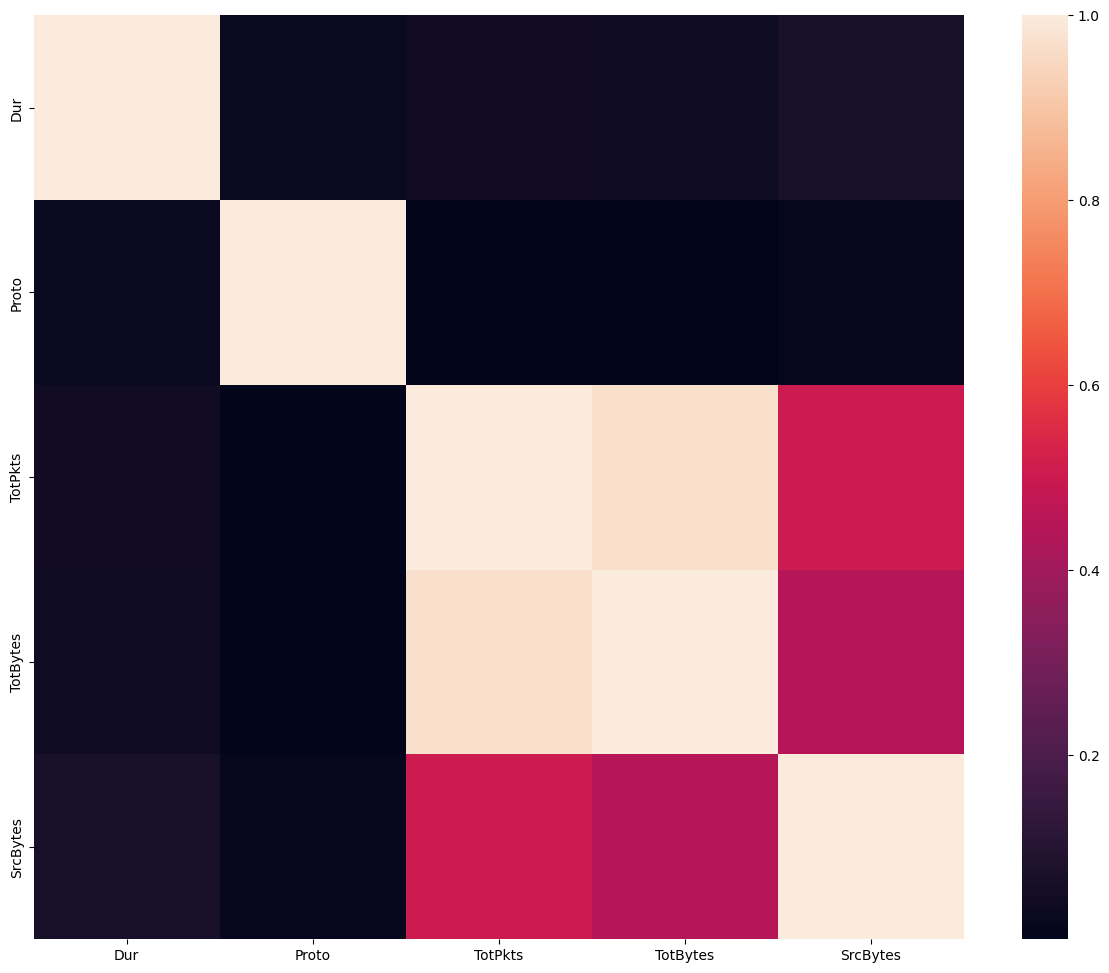

In [31]:
corr = df.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

In [32]:
cor_thr=0.98
print('Shape before feature reduction: ', df.shape)
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > cor_thr)]
print('Features to drop')
print(to_drop)
for i in to_drop:
    df.drop(i,axis = 1,inplace = True)
print('Shape after feature reduction: ', df.shape)

Shape before feature reduction:  (107251, 6)
Features to drop
[]
Shape after feature reduction:  (107251, 6)


C:\Users\crist\AppData\Local\Temp\ipykernel_9364\3168038546.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr().abs()


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Target variable and train set
Y = df[['Label']]
X = df.drop(['Label',], axis=1)

sc = MinMaxScaler()
X = sc.fit_transform(X)

# Split test and train data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

print(X)
print(Y)

(71858, 5) (35393, 5)
(71858, 1) (35393, 1)
[[8.55175071e-02 8.33333333e-02 8.63125362e-02 8.13261587e-02
  4.51966456e-02]
 [5.12433371e-01 8.33333333e-02 6.55323081e-01 2.62848077e-01
  3.09364151e-01]
 [1.00000000e+00 8.33333333e-02 1.58558999e-02 1.46017637e-02
  3.12756991e-01]
 ...
 [2.01587964e-19 0.00000000e+00 2.00428516e-06 9.16974790e-07
  2.01986021e-05]
 [2.65626633e-20 0.00000000e+00 2.00428516e-06 2.93749500e-07
  3.45387352e-06]
 [2.53271906e-20 0.00000000e+00 2.00428516e-06 2.91764706e-07
  2.88551459e-06]]
                                         Label
0                              flow=Background
1                              flow=Background
2                              flow=Background
3                              flow=Background
4                              flow=Background
...                                        ...
107246  flow=To-Background-UDP-CVUT-DNS-Server
107247      flow=Background-Attempt-cmpgw-CVUT
107248         flow=Background-UDP-Established


In [35]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping

def ann():
    model = Sequential()
    model.add(Dense(30,input_dim =5,activation = 'relu',kernel_initializer='random_uniform'))
    model.add(Dense(5,activation='sigmoid',kernel_initializer='random_uniform'))
    model.add(Dense(5,activation='softmax'))
    model.compile(loss ='categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])
    return model

model_ann = KerasClassifier(build_fn=ann,epochs=5,batch_size=64)
start_time = time.time()
callback = EarlyStopping(monitor='loss', patience=5)
model_ann.fit(X_train, Y_train.values.ravel(), callbacks=[callback])
time_train_ann = time.time() - start_time

Epoch 1/50


C:\Users\crist\AppData\Local\Temp\ipykernel_9364\3654629724.py:14: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model_ann = KerasClassifier(build_fn=ann,epochs=50,batch_size=64)


ValueError: in user code:

    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 52) and (None, 5) are incompatible


In [ ]:
loss = history.history['loss']
accuracy = history.history['accuracy']

print(loss)
print(accuracy)
    
plt.rcParams['figure.figsize'] = [10, 5]
plt.subplot(1, 2, 1)
plt.plot(range(0, 50), loss, 'bo', label='Training loss', color='red')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(0, 50), accuracy, 'bo', label='Training acc', color='red')
plt.title('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
def plot_confusion_matrix(Y_real, Y_pred, title=None):
    labels=np.unique(Y_real)
    nc=len(labels)
    data=np.zeros((nc,nc))
    pairs=zip(Y_real,Y_pred)
    pairs=list(pairs)
    for p in pairs: data[np.where(labels==p[0]),np.where(labels==p[1])]+=1
    row_total=np.sum(data,axis=1)
    data=data/row_total.reshape((nc,1))
    sns.set(color_codes=True)
    plt.figure(1, figsize=(9, 6))
    plt.title('Confusion Matrix') if title is None else plt.title(title)
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, annot=True, cmap='Blues', cbar_kws={'label': 'Scale'})
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set(ylabel='True Label', xlabel='Predicted Label')
    plt.show()
    
  
print('ANN evaluation')
start_time = time.time()
Y_train_pred=model_ann.predict(X_train)
Y_test_pred=model_ann.predict(X_test)
time_eval_ann=time.time()-start_time

print('Overall accuracy training: ', accuracy_score(Y_train,Y_train_pred))
print('Overall accuracy test: ', accuracy_score(Y_test,Y_test_pred))

print('Training time (seconds per sample): ', time_train_ann/float(Y_train.shape[0]))
print('Evaluation time (seconds per sample): ', 
time_eval_ann/(float(Y_train.shape[0])+float(Y_test.shape[0])))

plot_confusion_matrix(Y_train.values.ravel(),Y_train_pred, title='ANN - Training')
plot_confusion_matrix(Y_test.values.ravel(),Y_test_pred, title='ANN - Testing')
    
